In [1]:
%run init_notebook_space.py

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold

from yellowbrick.model_selection import LearningCurve

import lightgbm as lgb

import os
import joblib
import time

In [3]:
shap.initjs()

In [4]:
from settings import DATA_DIR

from functions import plot_learning_curve
from utils.analysis import print_regression_scores
from analysis.cust_seg_upsell._utils.data import plot_numeric_distributions, transform
from utils.utils import scale_and_split
from _utils.features import cast_data
from _utils._utils import transform, translate_negative_dist, get_2scatter, get_grouped_features

month = 'apr'
project = 'ks_lz'
random_state = 100
list_data_len = []

In [5]:
INPUT_DIR_MAP = os.path.join(DATA_DIR, 'input', 'map')
INPUT_DIR_MOD = os.path.join(DATA_DIR, 'input', 'modified', project)

OUTPUT_DIR = os.path.join(DATA_DIR, 'output', project)

DATA_ACC =  f'{project}_{month}_prepros_agg.feather'
TRANS_DICT = np.load(os.path.join(INPUT_DIR_MAP, f'{project}_{month}_trans_dict.npy'), allow_pickle='TRUE').item()

In [67]:
data = pd.read_feather(os.path.join(INPUT_DIR_MOD, DATA_ACC))
data = cast_data(data)
#list(data.columns)

'######## Check list definitions ########'
'######## Check for missing Columns in the listed cols ########'
'STATUS: Sanity check ran without finding any severe issues.'


In [68]:
data = data[[
#  'index',
 'ACCOUNT_ID',
 'ACCOUNT_DEVICEOUTPUT',
 'AKTUELLE_GESAMTRATE',
 'BETA_CORRECTED_ACCEPTENCE_RATE_ALL',
 'COUNT_ACCOUNT_ID',
 'DAC_CHECK',
 'DATEN_ANZAHLKN',
#  'DATEN_AUSG_GES',
 'DATEN_AUSG_GES_MIT_AKT_RATE',
 'DATEN_BEZIEHUNGKN',
 'DATEN_DEBTORADDRESSTOGETHER',
 'DATEN_EINKOMMEN_GES',
#  'DATEN_FVE',
#  'DATEN_FVE_NACH_AKT_RATE',
 'DATEN_KREDITSUMME_kanf',
 'DATEN_LAUFZEIT_kanf',
 'DATEN_MONATSRATE_kanf',
 'DATEN_VERWENDUNG_kanf',
#  'DELTA_KREDITSUMME',
#  'DELTA_KREDITSUMME_max',
#  'DELTA_KREDITSUMME_mean',
#  'DELTA_KREDITSUMME_median',
 'DELTA_KREDITSUMME_median_perc',
 'KREDITSUMME_kanf_UEBER_EINKOMMEN',
 'PERSON_ALTER_KN1',
 'PERSON_ALTER_KN2',
 'PERSON_ANREDE_KN1',
 'PERSON_ANREDE_KN2',
 'PERSON_FAMILIENSTAND_KN1',
 'PERSON_KR_DATEN_AG_BEFRISTET_KN1',
 'PERSON_KR_DATEN_AG_PROBEZEIT_KN1',
 'PERSON_KR_DATEN_AG_TAETIGSEIT_D_KN1',
 'PERSON_KR_DATEN_ANZAHLKINDER_KN1',
 'PERSON_KR_DATEN_ANZAHLPERSHH_KN1',
 'PERSON_KR_DATEN_AUSG_BAUSPAREN_KN1',
 'PERSON_KR_DATEN_AUSG_LV_KN1',
 'PERSON_KR_DATEN_AUSG_MIETE_KN1',
 'PERSON_KR_DATEN_AUSG_PKV_KN1',
 'PERSON_KR_DATEN_AUSG_UNTERHALT_KN1',
 'PERSON_KR_DATEN_AUSG_WOHNUNGSART_KN1',
 'PERSON_KR_DATEN_BERUFSGRUPPE_KN1',
 'PERSON_KR_DATEN_KFZ_KN1',
 'PERSON_KR_DATEN_PROPERTYOWNERSHIP_PROPERTYTYPE_KN1',
 'PERSON_KR_DATEN_WOHNHAFTSEIT_D_KN1',
 'PERSON_NATIONATLITAET_KN1',
 'PERSON_TITEL_KN1',
 'UMSCHULDUNG_RATE',
 'UMSCHULDUNG_RESIDUALDEBTORIGIN',
 'UPSELL',
 'UMSCHUL_RATE_UEBER_EINKOMMEN',
 'UMSCHUL_KS_UEBER_EINKOMMEN',
 'DATEN_FVE_NACH_AKT_RATE_NACH_KANF',
 'DATEN_KONTO_BANK',
 'UNEQL_KS',
 'GROUP_TIME_DELTA_KS_perc',
 'SCHUFA_SCORE_KN1',
#  'COUNT_MC_GI_KN1',
#  'COUNT_MC_GI_ER_KN1',
#  'COUNT_MC_KR_KN1',
#  'COUNT_MC_KR_ER_KN1',
#  'COUNT_MC_RK_KN1',
#  'COUNT_MC_RK_ER_KN1',
#  'COUNT_MC_CC_KN1',
#  'COUNT_MC_CC_ER_KN1',
#  'COUNT_MC_CR_KN1',
#  'COUNT_MC_CR_ER_KN1',
]]


y_col = ['DELTA_KREDITSUMME_median_perc']
categorical_features = list(data.select_dtypes(['int64', 'category', 'bool', 'string']).columns)
feature_names = data.drop(y_col, axis=1).columns

In [69]:
categorical_features

['ACCOUNT_ID',
 'ACCOUNT_DEVICEOUTPUT',
 'DAC_CHECK',
 'DATEN_ANZAHLKN',
 'DATEN_BEZIEHUNGKN',
 'DATEN_DEBTORADDRESSTOGETHER',
 'DATEN_VERWENDUNG_kanf',
 'PERSON_ALTER_KN2',
 'PERSON_ANREDE_KN1',
 'PERSON_ANREDE_KN2',
 'PERSON_FAMILIENSTAND_KN1',
 'PERSON_KR_DATEN_AG_BEFRISTET_KN1',
 'PERSON_KR_DATEN_AG_PROBEZEIT_KN1',
 'PERSON_KR_DATEN_AG_TAETIGSEIT_D_KN1',
 'PERSON_KR_DATEN_ANZAHLKINDER_KN1',
 'PERSON_KR_DATEN_ANZAHLPERSHH_KN1',
 'PERSON_KR_DATEN_AUSG_WOHNUNGSART_KN1',
 'PERSON_KR_DATEN_BERUFSGRUPPE_KN1',
 'PERSON_KR_DATEN_KFZ_KN1',
 'PERSON_KR_DATEN_PROPERTYOWNERSHIP_PROPERTYTYPE_KN1',
 'PERSON_KR_DATEN_WOHNHAFTSEIT_D_KN1',
 'PERSON_NATIONATLITAET_KN1',
 'PERSON_TITEL_KN1',
 'UPSELL',
 'DATEN_KONTO_BANK',
 'UNEQL_KS']

# Split data

In [70]:
data_trans = data.copy()

X_train, X_test, y_train, y_test = train_test_split(data_trans.drop(y_col,
                                                              axis=1),
                                                    data_trans[y_col],
                                                    test_size=0.3,
                                                    random_state=random_state)

In [71]:
X_train, X_test = get_grouped_features(df_in=pd.concat([X_train, y_train], axis=1),
                         df_in_test=X_test,
                        y_feature=y_col[0],
                         group_var='PERSON_NATIONATLITAET_KN1',
                         col_name='COUNTRY')

In [72]:
X_train, X_test = get_grouped_features(df_in=pd.concat([X_train, y_train], axis=1),
                                    df_in_test=X_test,
                                       y_feature=y_col[0],
                                    group_var='DATEN_KONTO_BANK',
                                    col_name='BANK',
                                    drop=True
                                      )

In [73]:
feature_names = X_train.columns
categorical_features = [item for item in categorical_features if item in X_train.columns]

In [74]:
scaler_x = StandardScaler().fit(X_train.drop(categorical_features, axis=1))
scaler_y = StandardScaler().fit(y_train)

In [75]:
X_train, scaled_cols_x = transform(X_train,
                                   scaler_x.transform, 
                                   X_train.drop(categorical_features, axis=1).columns, 
                                   method='entire')

y_train, scaled_cols_y = transform(y_train, 
                                   scaler_y.transform,
                                   y_col, 
                                   method='entire')

X_test, x = transform(X_test,
                      scaler_x.transform, 
                      X_test.drop(categorical_features, axis=1).columns, 
                      method='entire')

y_test, x = transform(y_test, 
                      scaler_y.transform,
                      y_col, 
                      method='entire')

# Train Model

In [76]:
lgb_model = lgb.LGBMRegressor(random_state=random_state)

lgb_model.fit(X_train,
              y_train,
              categorical_feature=categorical_features)

Using categorical_feature in Dataset.


LGBMRegressor(random_state=100)

In [77]:
y_pred = lgb_model.predict(X_test)

# Invers Trans

In [78]:
data_test = X_test.join(y_test)

In [79]:
data_test, x = transform(data_test,
                         scaler_x.inverse_transform,
                         scaled_cols_x,
                         method='entire')

In [80]:
data_test, x = transform(data_test,
                         scaler_y.inverse_transform,
                         scaled_cols_y,
                         method='entire')

In [81]:
data_test, x = transform(data_test,
                         np.expm1,
                         list(set(data_test.columns).intersection(set(TRANS_DICT['log_trans_cols']))))

In [82]:
data_test, x = translate_negative_dist(data_test,
                                       list(set(data_test.columns).intersection(set(TRANS_DICT['translation_cols']))),
                                       invers=True)

In [83]:
data_test['KS_pred_inv'] = y_pred.astype('float')

In [84]:
data_test, x = transform(data_test,
                         scaler_y.inverse_transform,
                         ['KS_pred_inv'],
                         method='entire')
print("ATTENTION: Y DATA IS INVERSE SCALED! HAS IT BEEN LOG TRANSFORMED OR TRANSLATED?")

data_test['KS_pred'] = y_pred
data_test['KS_true'] = y_test

data_test['KS_error'] = data_test.KS_true - data_test.KS_pred
data_test['KS_error_inv'] = data_test[y_col[0]] - data_test.KS_pred_inv

data_test['KS_error_inv_abs'] = abs(data_test[y_col[0]]- data_test.KS_pred_inv)

ATTENTION: Y DATA IS INVERSE SCALED! HAS IT BEEN LOG TRANSFORMED OR TRANSLATED?


# Model evaluation

In [85]:
#data_test['KS_pred_inv'] = data_test.KS_pred_inv.apply(lambda x: round(x, 2))

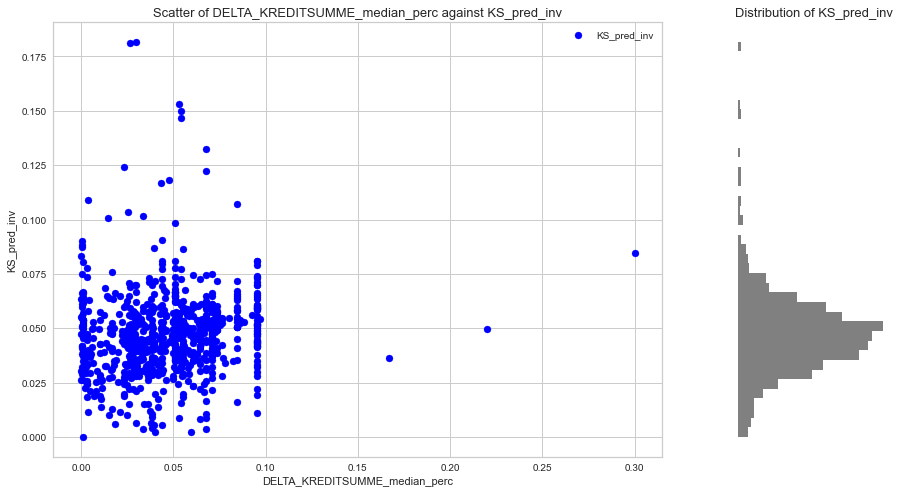

In [86]:
get_2scatter(data_test, plots=[y_col[0],
                               'KS_pred_inv'],
            bin_method='fd',
            line_scatter=False,
#             x_lim=(0, .15),
#             y_lim=(0, .12)
            )

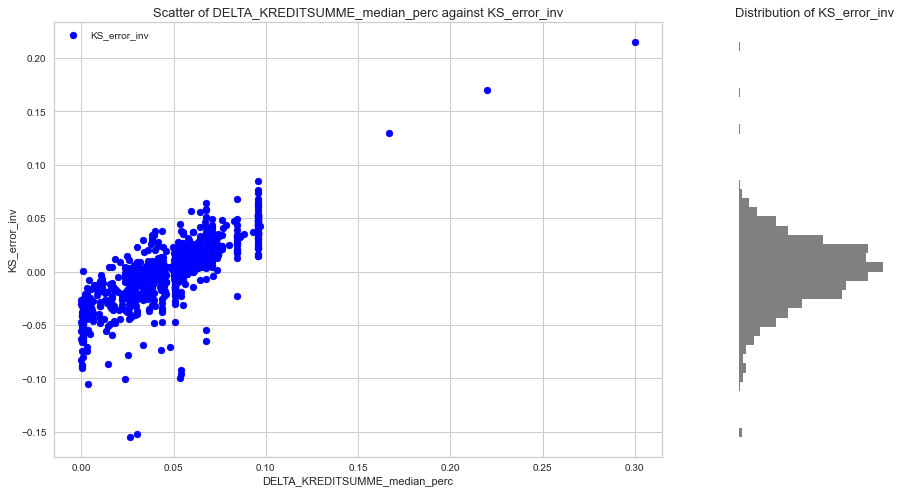

In [87]:
get_2scatter(data_test, plots=[y_col[0],
                               'KS_error_inv'],
            bin_method='fd',
            line_zero=False,
#             x_lim=(-.01, .2),
#             y_lim=(-.1, .2)
            )

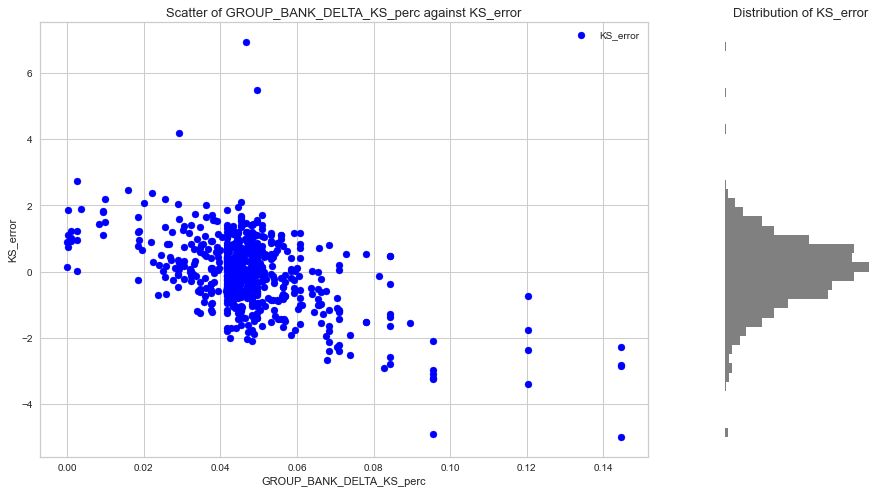

In [88]:
get_2scatter(data_test, plots=['GROUP_BANK_DELTA_KS_perc',
                                'KS_error'],
            bin_method='fd',
            line_zero=False)

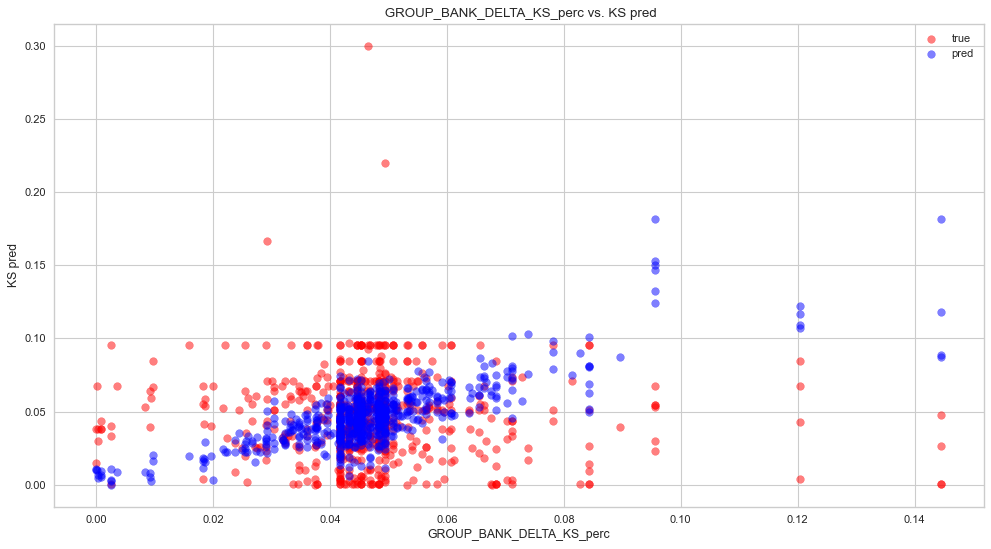

In [89]:
#Predictions
plotting_variable = 'GROUP_BANK_DELTA_KS_perc'

fig, ax = plt.subplots(figsize=(15, 8), dpi=80)


ax.scatter(x=data_test[plotting_variable],
           y=data_test[y_col[0]],
             color='red', 
             alpha=0.5)

ax.scatter(x=data_test[plotting_variable],
              y=data_test.KS_pred_inv,
              color='blue',
              alpha=0.5)

# ax.set_xlim(0, 150)
# ax.set_ylim(-.1, 0.15)

ax.set_title(f' {plotting_variable} vs. KS pred')
ax.set_xlabel(plotting_variable)
ax.set_ylabel('KS pred')
ax.legend(['true', 'pred'])

# Statssort_values

In [90]:
#performance in actual values

MSE = data_test['KS_error_inv'].apply(np.square)

MAE = data_test['KS_error_inv'].apply(abs)

print('###################################')
print(f'Test MSE: {round(MSE.mean(), 5)}')

print('###################################')
print(f'Test MAE: {round(MAE.mean(), 5)}')

print('###################################')
print(f'Test R2 score: {r2_score(y_true=y_test, y_pred=y_pred)}')

###################################
Test MSE: 0.00108
###################################
Test MAE: 0.0244
###################################
Test R2 score: -0.3125660388161309


In [91]:
print_regression_scores(lgb_model, X_train, y_train, X_test, y_test)

MSE on Train: 0.147
MSE on Test: 1.122

MAE on Train: 0.238
MAE on Test: 0.788


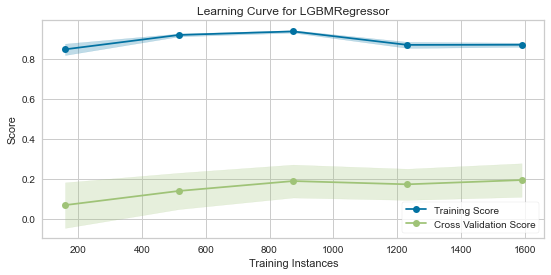

In [92]:
cv = KFold(n_splits=10, random_state=101, shuffle=True)
visualizer = LearningCurve(lgb_model, scoring='r2', cv=cv, random_state=101)

visualizer.fit(X_train, y_train)
visualizer.show();

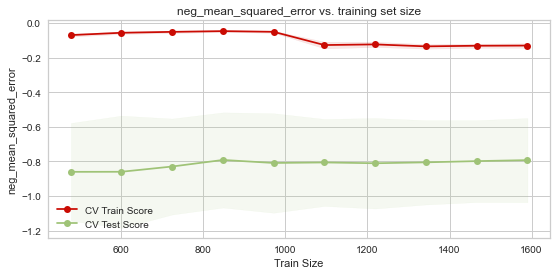

In [93]:
mpl.rcParams['figure.figsize'] = (9.0, 4.0)
plot, test_scores_std = plot_learning_curve(estimator=lgb_model,
                    X=X_train, y=y_train, 
                    ylim=None,
                    cv=cv,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1,
                    train_sizes=np.linspace(0.3, 1, 10),
                    random_state=1001)

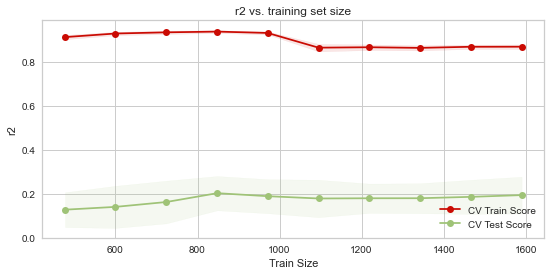

In [94]:
mpl.rcParams['figure.figsize'] = (9.0, 4.0)
plot, test_scores_std = plot_learning_curve(estimator=lgb_model,
                    X=X_train, y=y_train, 
                    ylim=None,
                    cv=cv,
                    scoring="r2",
                    n_jobs=-1,
                    train_sizes=np.linspace(0.3, 1, 10),
                    random_state=1001)

# Shap Values

In [95]:
shap_values = shap.TreeExplainer(lgb_model).shap_values(X_train)

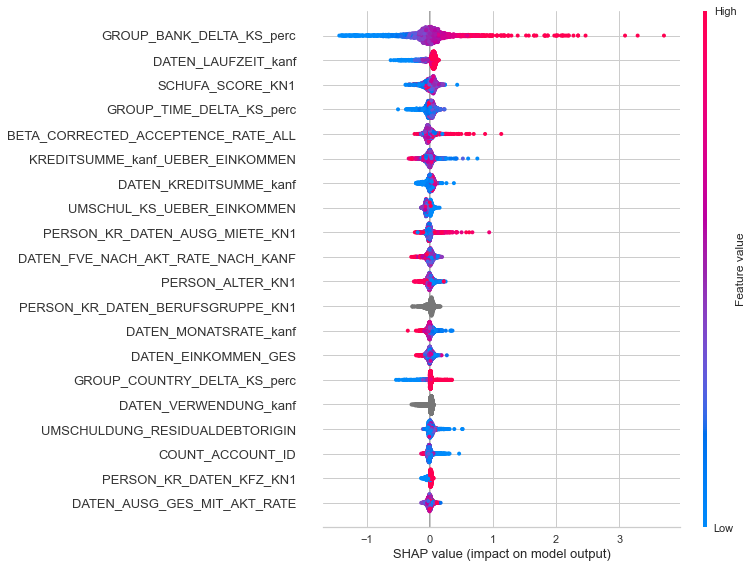

In [96]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

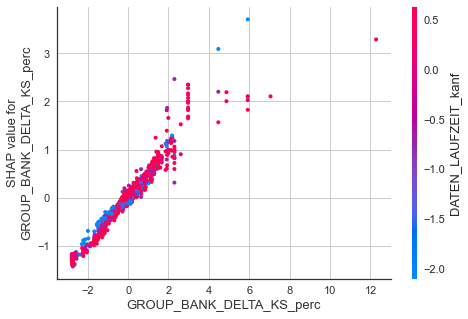

In [97]:
shap.dependence_plot('GROUP_BANK_DELTA_KS_perc', shap_values, X_train)

# Save Model

In [34]:
name = f"{project}_{month}_lgbm_median"
timestamp = time.strftime('%b-%d-%Y_%H_%M', time.localtime())
np.savetxt(os.path.join(OUTPUT_DIR, f'{name}_{timestamp}.txt'), [0, 1, 2])
f = open(os.path.join(OUTPUT_DIR, f'{name}_{timestamp}.txt'), 'w')


MSE = data_test['KS_error'].apply(np.square)
MSE_INV = data_test['KS_error_inv'].apply(np.square)

MAE = data_test['KS_error'].apply(abs)
MAE_INV = data_test['KS_error_inv'].apply(abs)

print(f"Model {name} {timestamp}", file=f)
print("""""", file=f)

print('###################################', file=f)
print(f'Test MSE: {round(MSE.mean(), 2)}', file=f)

print('###################################', file=f)
print(f'Test MSE inv: {round(MSE_INV.mean(), 2)}', file=f)

print('###################################', file=f)
print(f'Test MAE: {round(MAE.mean(), 2)}', file=f)

print('###################################', file=f)
print(f'Test MAE inv: {round(MAE_INV.mean(), 2)}', file=f)

print('###################################', file=f)
print(f'Test R2 score: {r2_score(y_true=y_test, y_pred=y_pred)}', file=f)

print('#####################################', file=f)
print('Feature input order', file=f)
print("""
""", file=f)
for item in feature_names:
    print(item, file=f)

print("""
""", file=f)
print(TRANS_DICT, file=f)

f.close()

joblib.dump(lgb_model, os.path.join(OUTPUT_DIR, f'{name}_{timestamp}.pkl'))
np.save(os.path.join(OUTPUT_DIR, f'{name}_dict_{timestamp}.npy'), TRANS_DICT)

joblib.dump(scaler_x, os.path.join(OUTPUT_DIR, f'scaler_x_{name}_{timestamp}.pkl'))
joblib.dump(scaler_y, os.path.join(OUTPUT_DIR, f'scaler_y_{name}_{timestamp}.pkl'))

['C:\\Users\\lukas.grahl\\Documents\\upsell\\data\\output\\ks_lz\\scaler_y_ks_lz_apr_lgbm_median_Jul-29-2021_17_38.pkl']

# Tuner

In [127]:
import optuna.integration.lightgbm as lgb_opt

d_train = lgb_opt.Dataset(X_train, label=y_train)
d_test = lgb_opt.Dataset(X_test, label=y_test)

params = {
    'metric' : 'mean_squared_error'
}

tuner = lgb_opt.LightGBMTuner(
    
    time_budget=2000,
    train_set=d_train,
    valid_sets=d_test,
    params=params,
    show_progress_bar=True
)

tuner.run()

list1 = []
list2 = []
for item in tuner.best_params:
    
    list1.append(item)
    list2.append(tuner.best_params[item])
    
best_params = dict(zip(list1, list2))

In [126]:
for item in tuner.best_params:
    
    list1.append(item)
    list2.append(tuner.best_params[item])
    
    print(f'{item}={tuner.best_params[item]},')

metric=l2,
feature_pre_filter=False,
lambda_l1=6.123925470455808,
lambda_l2=6.552304301064587e-06,
num_leaves=156,
feature_fraction=0.4,
bagging_fraction=1.0,
bagging_freq=0,
min_child_samples=20,


In [ ]:
"""
Optuna example that optimizes a classifier configuration for cancer dataset using LightGBM tuner.
In this example, we optimize the cross-validated log loss of cancer detection.
"""

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_opt

d_train= lgb_opt.Dataset(X_train, label=y_train)
d_test = lgb_opt.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric" : "binary_logloss-mean"
}

tuner = lgb_opt.LightGBMTunerCV(params,
                            d_train,
                            folds=KFold(n_splits=5),
                           )
tuner.run()

print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

# Tuner scale pos weight

1
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


2
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


3
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


4
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


5
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


6
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


7
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


8
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


9
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


10
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


11
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


12
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


13
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


14
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


15
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


16
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


17
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


18
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


19
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


20
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


21
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


22
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


23
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


24
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


25
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


26
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


27
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


28
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


29
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


30
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


31
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


32
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


33
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


34
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


35
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


36
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


37
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


38
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


39
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


40
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


41
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


42
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


43
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


44
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


45
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


46
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


47
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


48
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


49
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


50
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


51
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


52
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


53
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


54
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


55
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


56
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


57
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


58
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


59
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


60
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


61
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


62
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


63
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


64
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


65
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


66
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


67
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


68
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


69
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


70
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


71
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


72
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


73
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


74
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


75
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


76
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


77
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


78
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


79
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


80
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


81
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


82
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


83
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


84
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


85
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


86
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


87
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


88
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


89
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


90
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


91
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


92
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


93
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


94
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


95
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


96
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


97
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


98
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


99
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1.7789313080399424e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7789313080399424e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=5.6700854315125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6700854315125895
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.


#####################################
Best performing roc score at 9 for scale_pos_weight


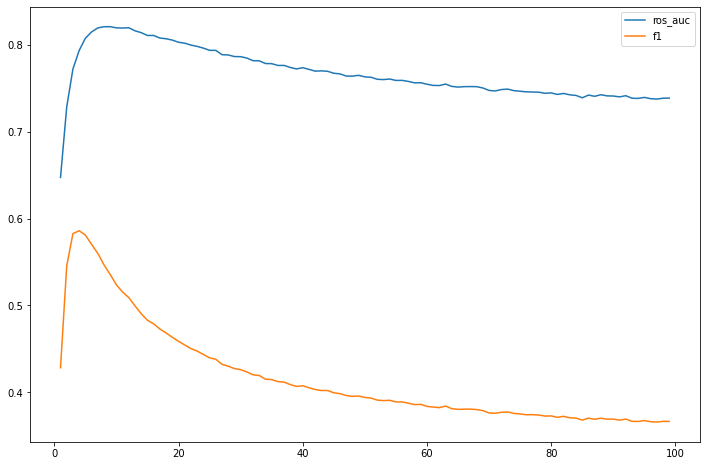

In [295]:
roc_list = []
f1_list = []
item_list = []

for item in range(1, 100, 1):
    
    print(item)
    
    lgb_model = lgb.LGBMClassifier(boosting_type='gbdt',
                           objective='binary',
                           feature_pre_filter= False, 
                           lambda_l1= 1.7789313080399424e-05,
                           lambda_l2= 5.6700854315125895,
                           num_leaves=250,
                           feature_fraction= 0.7,
                           bagging_fraction= 1.0,
                           bagging_freq= 0,
                           min_child_samples= 5,
                           random_state= 101,
                           #n_estimators=500,
                           #max_depth=-1,
                           #learning_rate=0.1,
                           #is_unbalanced=True,
                           #subsample_for_bin = 2000,
                           scale_pos_weight=item,
                           feature_name = feature_names)
    
    lgb_model.fit(X_train, y_train)
    
    y_pred = lgb_model.predict(X_test)
    
    roc_list.append(roc_auc_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    
    item_list.append(item)
    
df_scale = pd.DataFrame(data=[roc_list,
                              f1_list],
                       columns=item_list,
                       index=['roc', 'f1']).transpose()
    
plt.figure(figsize=(12, 8))

plt.plot(df_scale['roc'])
plt.plot(df_scale['f1'])

plt.legend(['ros_auc', 
            'f1'])

print('#####################################')
x = df_scale.nlargest(1, 'roc').index[0]
print(f'Best performing roc score at {x} for scale_pos_weight')

In [296]:
df_scale.nlargest(1, 'f1').index[0]

4